'''Exports a trained model into a frozen graph'''

/!\ Can't have 2 notebooks with tf.Sessions in parrallel !

Run from environment with requirements:
* TFOD All things
* humanfriendly
* *e.g use docker epic_cray in Cobbdam.*

# Freeze graph (.pbtxt to .pb)

In [1]:
import os
import tqdm
import numpy as np

#import tensorflow as tf
from tensorflow.python.tools import freeze_graph

In [4]:
path_to_root = '../../../..'
path_to_outputs = os.path.join(path_to_root,'outputs/fasterRCNN_07_02_img_resize')

pbtxt_path = os.path.join(path_to_outputs, 'graph.pbtxt')
ckpt_path = os.path.join(path_to_outputs, 'model.ckpt-300000')
frozen_graph_path = os.path.join(path_to_outputs, "frozen_graph_MergeSummary.pb")

In [9]:
freeze_graph.freeze_graph(input_graph=pbtxt_path,
                          input_saver='',input_binary=False,
                          input_checkpoint=ckpt_path,
                          output_node_names='Merge/MergeSummary', 
                          #output_node_names = 'group_deps', 
                          #output_node_names ? Found the last node name in pbtxt_file: 'Merge/MergeSummary'
                          # Or a random one in TensorBoard: 'group_deps', 
                          
                          restore_op_name='save/restore_all',
                          filename_tensor_name='save/Const:0',
                          output_graph=frozen_graph_path,
                          clear_devices=True,initializer_nodes='')


INFO:tensorflow:Restoring parameters from ../../../../outputs/fasterRCNN_07_02_img_resize/model.ckpt-300000
INFO:tensorflow:Froze 276 variables.
INFO:tensorflow:Converted 276 variables to const ops.


### Maanas' alternative way to freeze graph?

In [46]:
os.mkdir(os.path.join(path_to_root,'outputs/fasterRCNN_07_02_img_resize/export_inference'))
os.path.join(path_to_root,'outputs/fasterRCNN_07_02_img_resize/export_inference')

'../../../../outputs/fasterRCNN_07_02_img_resize/export_inference'

In [52]:
! python export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path ../../../../repos/dams/tfod/training/configs/07_02_imgsize_faster_rcnn_resnet50_coco.config \
    --trained_checkpoint_prefix ../../../../outputs/fasterRCNN_07_02_img_resize/model.ckpt-300000 \
    --output_directory ../../../../outputs/fasterRCNN_07_02_img_resize/export_inference \
    --write_inference_graph True

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
235 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-sho

235 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*,.*Initializer.*,.*Regularizer.*,.*BiasAdd.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================
Incomplete shape.

Doc:
scope: The nodes in the model graph are organiz

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1322, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1307, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1409, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.InternalError: Dst tensor is not initialized.
	 [[Node: save/RestoreV2/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_6_save/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: save/RestoreV2/_564 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/tas

# Inference

In [2]:
import argparse
import glob
import os
import sys
import time

import PIL
#import humanfriendly
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import tensorflow as tf
from tqdm import tqdm

In [55]:
from export_inference_graph import *
DEFAULT_CONFIDENCE_THRESHOLD = 0.85

/lib/tf/models/research/object_detection/utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tor

In [8]:
frozen_graph_path = os.path.join(path_to_root, "pre-trained-models/faster_rcnn_resnet50_coco/frozen_inference_graph.pb")
frozen_graph_path

'../../../../pre-trained-models/faster_rcnn_resnet50_coco/frozen_inference_graph.pb'

In [60]:
sample_img_path = os.path.join(path_to_root,'data/Sample_imagery_6-7/116500_clipped.png')
sample_img_path


'../../../../data/Sample_imagery_6-7/116500_clipped.png'

In [56]:
detection_graph = load_model(frozen_graph_path)
detection_graph

In [61]:
boxes,scores,classes,images = generate_detections(detection_graph,sample_img_path)


100%|██████████| 1/1 [00:00<00:00, 49.91it/s]
0it [00:00, ?it/s]

Loading images...
Finished loading 1 file(s) in 0.02 seconds
Running detector...


1it [00:05,  5.16s/it]

Finished running detector in 5.16 seconds


In [62]:
outputDir = os.path.join(path_to_outputs, 'infered_sample') 
outputFileName = os.path.join(outputDir, 'test_sample_img2.png') 

In [63]:
render_bounding_boxes(boxes,
                      scores,
                      classes,
                      inputFileNames=[sample_img_path],
                      outputFileNames=[outputFileName],
                      confidenceThreshold=DEFAULT_CONFIDENCE_THRESHOLD,
                      linewidth=DEFAULT_LINE_WIDTH)

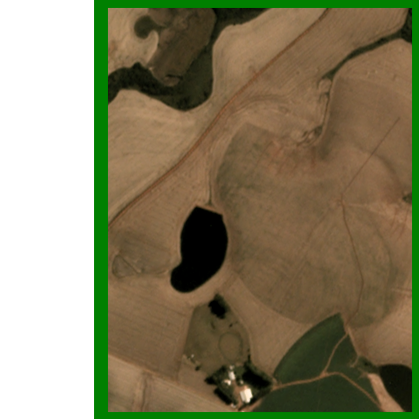

In [64]:
from IPython.display import Image
Image(filename=outputFileName) 